In [118]:
import galprime as gp

import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from astropy.modeling import models

from matplotlib import pyplot as plt

gp.plotting.pyplot_style()

In [119]:
config = gp.read_config_file("myconfig.gprime")
gp_obj = gp.load_object("output_handling_2/tempfiles/6021858_0_0_0_2_done.pkl")

print(dir(gp_obj))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'background', 'bg', 'bg_added_model', 'bg_model', 'bg_params', 'bgsub', 'condensed_output', 'config', 'convolved_model', 'id', 'isophote_lists', 'logger', 'mask_bgadded', 'mask_bgsub', 'mask_data_bgadded', 'mask_data_bgsub', 'metadata', 'model', 'model_image', 'model_params', 'params', 'process', 'psf', 'save_output', 'source_mask', 'stop_code']


In [137]:

def plot_model(obj, config, **kwargs):

    fontsize = kwargs.get("fontsize", 8)

    fig, ax = plt.subplots(2, 4, figsize=kwargs.get("figsize", (12, 6.5)), facecolor="white")

    lims = ZScaleInterval(contrast=0.1).get_limits(obj.bg)

    cmap = "Greys"

    ax[0, 0].imshow(obj.convolved_model, origin="lower", cmap=cmap, vmin=lims[0], vmax=lims[1])
    obj.model.plot_model_params(axis=ax[0, 0], fontsize=fontsize - 4, exclude=["X0", "Y0", "SHAPE"])
    ax[0, 0].set_title("Convolved Model", fontsize=fontsize)

    img = ax[0, 1].imshow(obj.bg, origin="lower", cmap=cmap, vmin=lims[0], vmax=lims[1])
    ax[0, 1].text(0.05, 0.95, f'BG_INDEX = {obj.metadata["BG_INDEX"]}', transform=ax[0, 1].transAxes,
                fontsize=fontsize - 4, color='black', va='top', ha='left', bbox=dict(facecolor='white', alpha=0.5))
    ax[0, 1].set_title("Background", fontsize=fontsize)

    cbar_ax = ax[0, 1].inset_axes([0.05, 0.05, 0.5, 0.05])  # [left, bottom, width, height]

    coadd = obj.bg + obj.convolved_model
    coadd[obj.mask_bgadded] = np.nan

    ax[0, 2].imshow(coadd, origin="lower", cmap=cmap, vmin=lims[0], vmax=lims[1])
    ax[0, 2].set_title("Coadded Model (Masked)", fontsize=fontsize)

    ax[0, 3].imshow(obj.source_mask, origin="lower", cmap="gray", vmin=0, vmax=1)
    ax[0, 3].set_title("Source Mask", fontsize=fontsize)

    bg_model_lims = ZScaleInterval(contrast=0.1).get_limits(obj.bg_model)
    ax[1, 0].imshow(obj.bg_model, origin="lower", cmap=cmap, vmin=bg_model_lims[0], vmax=bg_model_lims[1])
    ax[1, 0].set_title("Background Model", fontsize=10)


    ax[1, 1].imshow(obj.bgsub, origin="lower", cmap=cmap, vmin=lims[0], vmax=lims[1])
    ax[1, 1].set_title("Background Subtracted", fontsize=fontsize)
    # print(obj.metadata)
    plt.suptitle(f"Object ID: {obj.metadata['ID']}", fontsize=fontsize)
    
    bgsub = obj.bgsub.copy()
    bgsub[obj.mask_bgsub] = np.nan
    ax[1, 2].imshow(bgsub, origin="lower", cmap=cmap, vmin=lims[0], vmax=lims[1])
    ax[1, 2].set_title("BG Subtracted (Masked)", fontsize=fontsize)


    for n, color, label in zip(obj.isophote_lists, ["red", "blue", "gold"], ["MODEL", "COADD", "BGSUB"]):
        n = n["ISOLIST"]
        sb = gp.to_sb(n.intens)
        low = gp.to_sb(n.intens - 3 * n.int_err)
        high = gp.to_sb(n.intens + 3 * n.int_err)
        ax[1, 3].plot(n.sma, sb, color=color)
        ax[1, 3].fill_between(n.sma, low, high, color=color, alpha=0.2)
    prof_ylims = kwargs.get("prof_ylims", (31, 24))
    ax[1, 3].set_ylim(prof_ylims[0], prof_ylims[1])
    ax[1, 3].set_title("Profiles", fontsize=fontsize)
    ax[1, 3].set_xscale("log")

    for axis in ax.flatten()[:-1]:
        axis.set(xticks=[], yticks=[])
    
    plt.tight_layout()

    filename = kwargs.get("filename", None)
    if filename:
        plt.savefig(filename, dpi=kwargs.get("dpi", 150), bbox_inches="tight")
        plt.close()
    else:
        plt.show()



plot_model(gp_obj, config, fontsize=14, filename="test_save.png")



/Users/hsouch/Dropbox/GalPRIME/galprime/utils/fluxes.py:28: RuntimeWarning: invalid value encountered in log10
  sb = -2.5 * np.log10(f / (arcconv ** 2)) + m_0


2


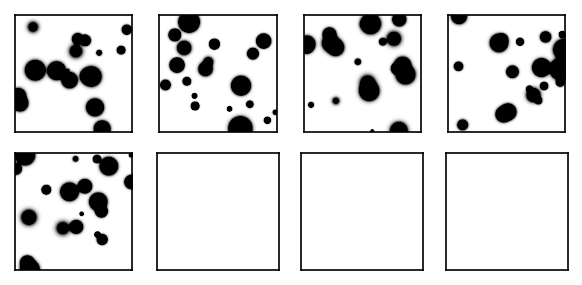

In [2]:
test = galprime.BackgroundModels()
   

class GaussianField(galprime.BackgroundModels):

    def __init__(self):
        super().__init__()
    
    def gen_single(self, **kwargs):
        bg_info = {}
        n_objects = kwargs.get('n_objects', 20)
        std_range = kwargs.get('std_range', (1, 5))
        amp_range = kwargs.get('amp_range', (0.1, 10))
        size = kwargs.get('size', 151)
        x0, y0 = kwargs.get('x0', size/2), kwargs.get('y0', size/2)

        min_dist = kwargs.get('min_dist', 5)
        max_attempts = kwargs.get('max_attempts', 1000)

        bg = np.zeros((size, size))

        ys, xs =  np.mgrid[0:size, 0:size]

        for i in range(n_objects):
            attempts, good = 0, False
            while not good:
                if attempts > max_attempts:
                    break
                x, y = np.random.uniform(0, size, 2)
                if np.sqrt((x - x0)**2 + (y - y0)**2) < min_dist:
                    attempts += 1
                    continue
                std = np.random.uniform(std_range[0], std_range[1])
                amp = np.random.uniform(amp_range[0], amp_range[1])
                g = models.Gaussian2D(amp, x, y, std, std)
                bg += g(xs, ys)
                good = True
        return bg, bg_info 

gf = GaussianField()
gf.populate(n_models=5)

galprime.plotting.show_cutouts(gf, ncols=4, figsize=1)

In [3]:

class SersicField(galprime.BackgroundModels):

    def __init__(self):
        super().__init__()
    
    def gen_single(self, **kwargs):
        bg_info = {}
        n_objects = kwargs.get('n_objects', 20)                 # Number of objects
        mag_range = kwargs.get('mag_range', (22, 27))           # Magnitude range
        reff_range = kwargs.get('reff_range', (1, 5))           # Effective radius range
        n_range = kwargs.get('n_range', (0.5, 4.5))             # Sersic index range
        ellip_range = kwargs.get('ellip_range', (0.1, 0.9))     # Ellipticity range

        size = kwargs.get('size', 151)
        x0, y0 = kwargs.get('x0', size/2), kwargs.get('y0', size/2)

        min_dist = kwargs.get('min_dist', 5)
        max_attempts = kwargs.get('max_attempts', 1000)

        bg = np.zeros((size, size))

        ys, xs =  np.mgrid[0:size, 0:size]

        for i in range(n_objects):
            attempts, good = 0, False
            while not good:
                if attempts > max_attempts:
                    break
                x, y = np.random.uniform(0, size, 2)
                if np.sqrt((x - x0)**2 + (y - y0)**2) < min_dist:
                    attempts += 1
                    continue
                
                mag = np.random.uniform(mag_range[0], mag_range[1])
                reff = np.random.uniform(reff_range[0], reff_range[1])
                n = np.random.uniform(n_range[0], n_range[1])
                ellip = np.random.uniform(ellip_range[0], ellip_range[1])
                pa = np.random.uniform(0, np.pi)
                

                good = True

        return bg, bg_info

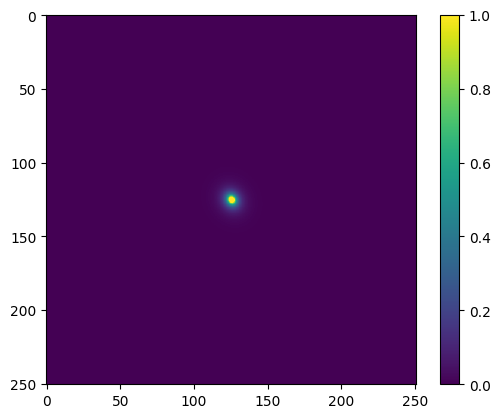

In [4]:


plt.imshow(galprime.gen_single_sersic(SHAPE=251, REFF=np.random.uniform(1, 10), N=np.random.uniform(0.5, 4.5),
                                       ELLIP=np.random.uniform(0.1, 0.9), MAG=22)[0], vmin=0, vmax=1)
plt.colorbar()

{'MAG': 24, 'M0': 27, 'REFF': 10.0, 'N': 1.0, 'ELLIP': 0.3, 'PA': 1.9118155054674877, 'X0': 225.5, 'Y0': 225.5, 'SHAPE': (451, 451)}
15.848931924611126


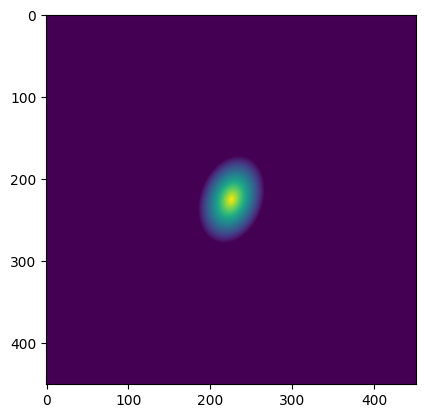

In [10]:
c = galprime.read_config_file("myconfig.gprime")

mod = galprime.SingleSersicModel()
z, params = mod.generate(params={"SHAPE":c["MODEL"]["SIZE"], "REFF":10, "N": 1, "MAG":24, "M0":27})

plt.imshow(np.log10(z), vmin=-5, vmax=-1)
print(mod.params)
print(np.sum(z))